In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipm.utils import ipm_transform, Info

In [22]:
import cv2
import numpy as np
import math

PI = 3.1415926

frameWidth = 640
frameHeight = 480

def update_perspective(source):
    alpha = (cv2.getTrackbarPos("Alpha", "Result") - 90) * PI / 180
    beta = (cv2.getTrackbarPos("Beta", "Result") - 90) * PI / 180
    gamma = (cv2.getTrackbarPos("Gamma", "Result") - 90) * PI / 180
    focalLength = cv2.getTrackbarPos("f", "Result")
    dist = cv2.getTrackbarPos("Distance", "Result")

    image_size = (frameWidth, frameHeight)
    w, h = image_size

    A1 = np.array([[1, 0, -w / 2],
                [0, 1, -h / 2],
                [0, 0, 0],
                [0, 0, 1]], dtype=np.float32)

    RX = np.array([[1, 0, 0, 0],
                [0, math.cos(alpha), -math.sin(alpha), 0],
                [0, math.sin(alpha), math.cos(alpha), 0],
                [0, 0, 0, 1]], dtype=np.float32)

    RY = np.array([[math.cos(beta), 0, -math.sin(beta), 0],
                [0, 1, 0, 0],
                [math.sin(beta), 0, math.cos(beta), 0],
                [0, 0, 0, 1]], dtype=np.float32)

    RZ = np.array([[math.cos(gamma), -math.sin(gamma), 0, 0],
                [math.sin(gamma), math.cos(gamma), 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]], dtype=np.float32)

    R = np.dot(np.dot(RX, RY), RZ)

    T = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, dist],
                [0, 0, 0, 1]], dtype=np.float32)

    K = np.array([[focalLength, 0, w / 2, 0],
                [0, focalLength, h / 2, 0],
                [0, 0, 1, 0]], dtype=np.float32)

    transformationMat = np.dot(np.dot(np.dot(K, T), R), A1)

    destination = cv2.warpPerspective(source, transformationMat, image_size, flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)

    return destination

cv_image = cv2.imread('images/input6.png')
transformed_image = update_perspective(cv_image)
plt.imshow(np.asarray(transformed_image, dtype=int))

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2561: error: (-27:Null pointer) NULL window: 'Result' in function 'cvGetTrackbarPos'


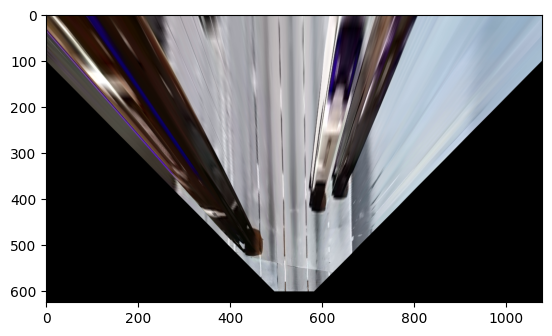

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def birdseye_transform(camera_image, inverse=False):
    # desired_width, desired_height = 512, 512

    # # Dummy intrinsic parameters
    # focal_length = 720 # Focal length in pixels
    # principal_point = (640, 360) # Principal point in pixels (x, y)
    # # Dummy extrinsic parameters
    # rotation_matrix = np.array([[1., 0, 0], [0, 1, 0], [0, 0, 1]]) # Identity matrix
    # translation_vector = np.array([0., 0, 5]) # Translation in world units (x, y, z)
    # # Create camera matrix from intrinsic parameters
    # camera_matrix = np.array([[focal_length, 0., principal_point[0]],
    # [0, focal_length, principal_point[1]],
    # [0, 0, 1]])
    # # Create the extrinsic matrix from rotation and translation
    # # extrinsic_matrix = np.hstack((rotation_matrix, translation_vector.reshape(3, 1)))
    # extrinsic_matrix = rotation_matrix
    # # Compute homography matrix using camera matrix and extrinsic matrix
    # homography_matrix = np.dot(camera_matrix, extrinsic_matrix)

    # # Step 1: Load the camera image
    # # Step 2: Define the ROI in the camera image (four perspective points)
    # # x1, y1, x2, y2, x3, y3, x4, y4 = 1280, 360, 0, 360, 0, 720, 1280, 720
    # # targeted rectangle on original image which needs to be transformed
    # tl = [0 + 560, 500]
    # tr = [1280 - 560, 500]
    # br = [1280, 720]
    # bl = [0, 720]

    # corner_points_array = np.float32([tl,tr,br,bl])

    # # original image dimensions
    # width = 1280
    # height = 720

    # # Create an array with the parameters (the dimensions) required to build the matrix
    # imgTl = [0,0]
    # imgTr = [width,0]
    # imgBr = [width,height]
    # imgBl = [0,height]
    # img_params = np.float32([imgTl,imgTr,imgBr,imgBl])

    # # Compute and return the transformation matrix
    # matrix = cv2.getPerspectiveTransform(corner_points_array, img_params)
    # img_transformed = cv2.warpPerspective(camera_image, matrix, (width,height))
    # return img_transformed
    # # perspective_points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.float32)
    # # Step 3: Compute the homography matrix using perspective points
    # # dest_points = np.array([[0, 0], [desired_width, 0], [desired_width, desired_height], [0, desired_height]], dtype=np.float32)
    # # homography_matrix = cv2.getPerspectiveTransform(perspective_points, dest_points)
    # # Step 4: Perform perspective transformation
    # print(camera_matrix.dtype)
    # print(extrinsic_matrix.dtype)
    # print(homography_matrix.dtype)
    # birdseye_view = cv2.warpPerspective(camera_image, homography_matrix, (desired_width, desired_height))
    # return birdseye_view

    # H_OFFSET = 500
    # IMAGE_H = 720 - H_OFFSET
    # IMAGE_W = 1280

    # src = np.float32([[0, IMAGE_H], [1280, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    # dst = np.float32([[H_OFFSET, IMAGE_H], [720, IMAGE_H], [0, 0], [IMAGE_W, 0]])

    OUT_H_FACTOR = 8
    IMAGE_H = 223
    IMAGE_W = 1280

    # src = np.float32([[0, IMAGE_H], [1207, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    # dst = np.float32([[569, IMAGE_H], [711, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    src = np.float32([[0, 625], [1280, 625], [0, 0], [1280, 0]])
    dst = np.float32([[620, 625], [1280-620, 625], [0, 0], [1280, 0]])

    # src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H], [848, 189], [927, 189]])
    # dst = np.float32([[500, IMAGE_H * OUT_H_FACTOR], [IMAGE_W - 500, IMAGE_H * OUT_H_FACTOR], [500, 0], [IMAGE_W - 500, 0]])

    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    img = camera_image[440:, :] # Apply np slicing for ROI crop
    warped_img = cv2.warpPerspective(img, M if not inverse else Minv, (1280, 625)) # Image warping
    return warped_img
    # # return cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)
    # plt.imshow() # Show results
    # plt.show()

    # focal_length = 720 # Focal length in pixels
    # principal_point = (640, 360) # Principal point in pixels (x, y)
    # intrinsics = [[focal_length, 0., principal_point[0]],
    #               [0, focal_length, principal_point[1]],
    #               [0, 0, 1]]
    # intrinsics_matrix = np.array(intrinsics, dtype='float32')
    # #In the intrinsics we have parameters such as focal length and the principal point

    # extrinsics = np.array([[1, 0, 0, 0],
    #               [0, 1, 0, 1.5],
    #               [0, 0, 1, 0]])
    # #The extrinsic matrix stores the position of the camera in global space
    # #The 1st 3 columns represents the rotation matrix and the last is a translation vector
    # extrinsics = extrinsics[:, [0, 1, 3]]
    # extrinsics_matrix = np.array(extrinsics, dtype='float32')
    # extrinsics_matrix = intrinsics_matrix

    # #We removed the 3rd column of the extrinsics because it represents the z coordinate (0)
    # projection_matrix = np.matmul(intrinsics_matrix, extrinsics_matrix)

    # # Compute the new coordinates of our points - cv2.perspectiveTransform expects shape 3
    # # list_points_to_detect = np.array([[point_x_y]], dtype=np.float32)
    # # transformed_points = cv2.perspectiveTransform(list_points_to_detect, projection_matrix)
    # transformed_points = cv2.perspectiveTransform(camera_image, projection_matrix)

    # # Dummy intrinsic parameters
    # focal_length = 1000.0 # Focal length in pixels
    # principal_point = (320, 240) # Principal point in pixels (x, y)
    # # Dummy extrinsic parameters
    # rotation_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) # Identity matrix
    # translation_vector = np.array([0, 0, 5]) # Translation in world units (x, y, z)
    # # Create camera matrix from intrinsic parameters
    # camera_matrix = np.array([[focal_length, 0, principal_point[0]],
    # [0, focal_length, principal_point[1]],
    # [0, 0, 1]])
    # # Create the extrinsic matrix from rotation and translation
    # extrinsic_matrix = np.hstack((rotation_matrix, translation_vector.reshape(3, 1)))
    # # Compute homography matrix using camera matrix and extrinsic matrix
    # homography_matrix = np.matmul(camera_matrix, extrinsic_matrix)
    # homography_matrix = homography_matrix[:, [0, 1, 2]]
    # print(homography_matrix)

    # # Step 2: Define the ROI in the camera image (four corners)
    # x1, y1, x2, y2, x3, y3, x4, y4 = 1280, 360, 0, 360, 0, 720, 1280, 720
    # roi_corners = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.float32)

    # # Step 3: Compute the bird's-eye view transformation using the homography matrix
    # desired_width, desired_height = 1280, 720
    # birdseye_view = cv2.warpPerspective(camera_image[360:], homography_matrix, (desired_width, desired_height))
    # return birdseye_view


cv_image = cv2.imread('images/input7.png')
transformed_image = birdseye_transform(cv_image)[:, 100:1280-100]
plt.imshow(np.asarray(transformed_image, dtype=int))

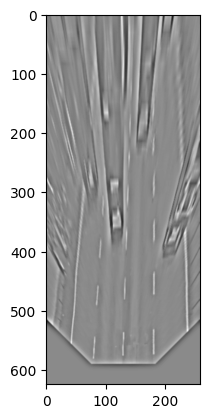

In [72]:
# import numpy as np

# gray_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2GRAY)
# gray_image = cv2.GaussianBlur(gray_image, (3,3), 0)

# # Method 1
# sobelx = cv2.Sobel(src=gray_image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
# l = 10
# f1 = cv2.filter2D(sobelx, -1, kernel=np.array([1 if i <= l else -1 for i in range(2*l + 1)]))
# f2 = abs(cv2.filter2D(sobelx, -1, kernel=np.array([1 for i in range(2*l + 1)])))
# rx = f1 - f2
# (raccent, threshInv) = cv2.threshold(rx, 100, 255, cv2.THRESH_BINARY_INV)

# # Method 2
# y_highpass = gray_image - cv2.GaussianBlur(gray_image, (0,0), sigmaX=5) + 127
# x_lowpass = cv2.GaussianBlur(y_highpass, (0,0), sigmaX=30)


# plt.imshow(np.asarray(y_highpass, dtype=int), cmap='gray')

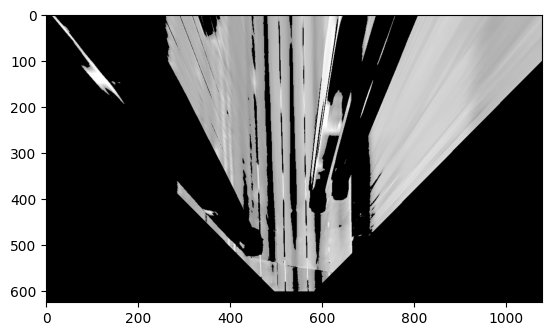

In [25]:
lower_yellow = np.array([20, 100, 100], dtype=np.uint8)
upper_yellow = np.array([30, 255, 255], dtype=np.uint8)

hsv_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2HSV)
gray_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2GRAY)

mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
mask_white = cv2.inRange(gray_image, 150, 255)
mask_yw = cv2.bitwise_or(mask_white, mask_white)

mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)
plt.imshow(mask_yw_image, cmap='gray')


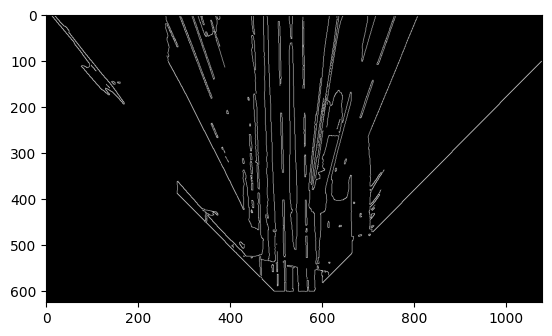

In [26]:
kernel_size = 5
gauss_gray = cv2.GaussianBlur(mask_yw_image, (kernel_size, kernel_size), 0)

low_threshold = 50
high_threshold = 150
canny_edges = cv2.Canny(gauss_gray, low_threshold, high_threshold)
plt.imshow(canny_edges, cmap='gray')

In [27]:
#used below
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

#thick red lines 
def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """workflow:
    1) examine each individual line returned by hough & determine if it's in left or right lane by its slope
    because we are working "upside down" with the array, the left lane will have a negative slope and right positive
    2) track extrema
    3) compute averages
    4) solve for b intercept 
    5) use extrema to solve for points
    6) smooth frames and cache
    """
    global cache
    global first_frame
    y_global_min = img.shape[0] #min will be the "highest" y value, or point down the road away from car
    y_max = img.shape[0]
    l_slope, r_slope = [],[]
    l_lane,r_lane = [],[]
    det_slope = 0.4
    α =0.2 
    #i got this alpha value off of the forums for the weighting between frames.
    #i understand what it does, but i dont understand where it comes from
    #much like some of the parameters in the hough function
    
    for line in lines:
        #1
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            if (slope == np.inf or slope == -np.inf):
                continue
            if np.rad2deg(np.arctan(abs(slope))) < 75 or np.rad2deg(np.arctan(abs(slope))) > 105:
                continue
            if slope > det_slope:
                r_slope.append(slope)
                r_lane.append(line)
            elif slope < -det_slope:
                l_slope.append(slope)
                l_lane.append(line)
        #2
        y_global_min = min(y1,y2,y_global_min)
    
    # to prevent errors in challenge video from dividing by zero
    if((len(l_lane) == 0) or (len(r_lane) == 0)):
        print ('no lane detected')
        return 1
        
    #3
    l_slope_mean = np.mean(l_slope,axis =0)
    r_slope_mean = np.mean(r_slope,axis =0)
    l_mean = np.mean(np.array(l_lane),axis=0)
    r_mean = np.mean(np.array(r_lane),axis=0)
    
    if ((r_slope_mean == 0) or (l_slope_mean == 0 )):
        print('dividing by zero')
        return 1
    
   
    
    #4, y=mx+b -> b = y -mx
    l_b = l_mean[0][1] - (l_slope_mean * l_mean[0][0])
    r_b = r_mean[0][1] - (r_slope_mean * r_mean[0][0])
    
    #5, using y-extrema (#2), b intercept (#4), and slope (#3) solve for x using y=mx+b
    # x = (y-b)/m
    # these 4 points are our two lines that we will pass to the draw function
    print(y_global_min, l_b, l_slope_mean)
    l_x1 = int((y_global_min - l_b)/l_slope_mean) 
    l_x2 = int((y_max - l_b)/l_slope_mean)   
    r_x1 = int((y_global_min - r_b)/r_slope_mean)
    r_x2 = int((y_max - r_b)/r_slope_mean)
    
    #6
    if l_x1 > r_x1:
        l_x1 = int((l_x1+r_x1)/2)
        r_x1 = l_x1
        l_y1 = int((l_slope_mean * l_x1 ) + l_b)
        r_y1 = int((r_slope_mean * r_x1 ) + r_b)
        l_y2 = int((l_slope_mean * l_x2 ) + l_b)
        r_y2 = int((r_slope_mean * r_x2 ) + r_b)
    else:
        l_y1 = y_global_min
        l_y2 = y_max
        r_y1 = y_global_min
        r_y2 = y_max
      
    current_frame = np.array([l_x1,l_y1,l_x2,l_y2,r_x1,r_y1,r_x2,r_y2],dtype ="float32")
    
    if first_frame == 1:
        next_frame = current_frame        
        first_frame = 0        
    else :
        prev_frame = cache
        next_frame = (1-α)*prev_frame+α*current_frame
             
    cv2.line(img, (int(next_frame[0]), int(next_frame[1])), (int(next_frame[2]),int(next_frame[3])), color, thickness)
    cv2.line(img, (int(next_frame[4]), int(next_frame[5])), (int(next_frame[6]),int(next_frame[7])), color, thickness)
    
    cache = next_frame

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_lines_raw(img, lines):
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            if np.rad2deg(np.arctan(abs(slope))) < 80 or np.rad2deg(np.arctan(abs(slope))) > 110:
                continue
            cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 10)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    # print(lines)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    draw_lines_raw(line_img, lines)
    return line_img

#rho and theta are the distance and angular resolution of the grid in Hough space
#same values as quiz
rho = 4
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 225
min_line_len = 300
max_line_gap = 180
#my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

first_frame = 1
hough_lines_img = hough_lines(canny_edges, rho, theta, threshold, min_line_len, max_line_gap)
result = weighted_img(hough_lines_img, transformed_image, α=0.8, β=1., λ=0.)

# plt.imshow(result, cmap='gray')
plt.imsave('lane_reconstruction.png', result)

In [285]:
def interpolate_hough(img, lines):
    height, width = img.shape
    interploated_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            # straight line
            if x1 == x2:
                interploated_lines.append([(x1, 0, x2, height)])
                continue
            
            # not straight line
            # if the line is too horizontal, skip
            slope = get_slope(x1,y1,x2,y2)
            if np.rad2deg(np.arctan(abs(slope))) < 80 or np.rad2deg(np.arctan(abs(slope))) > 110:
                continue
            
            m_inv = (x2-x1)/(y2-y1)
            interpolated_x1 = m_inv * (0 - y1) + x1
            interpolated_x2 = m_inv * (height - y1) + x1
            interploated_lines.append([(interpolated_x1, 0, interpolated_x2, height)])
    return np.asarray(interploated_lines, dtype=np.int32)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines_interpolated = interpolate_hough(img, lines)
    lines_interpolated = filter_merge_hough(img, lines_interpolated)
    # return lines
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    draw_lines_raw(line_img, lines_interpolated)
    return line_img

def filter_merge_hough(img, lines, lane_width=15):
    filtered = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            matched = False
            for l in range(len(filtered)):
                closest = 10000000
                for x1f, y1f, x2f, y2f in filtered[l]:
                    if x1f == np.inf:
                        if abs(x2-x2f) < lane_width and abs(x2-x2f) < closest:
                            filtered[l] = [(x1, y1, (x2 + x2f)/2, y2)]
                            matched = True
                            closest = abs(x2-x2f)
                    elif abs(x1-x1f) < lane_width or abs(x2-x2f) < lane_width:
                        filtered[l] = [((x1 + x1f)/2, y1, (x2 + x2f)/2, y2)]
                        matched = True
            if matched == False:
                filtered.append([(x1, y1, x2, y2)])
    
    return np.asarray(filtered, dtype=np.int32)

# Return [[x11, x12, ..., xmn], ..., [xi1, ..., xmn]]
def multi_segment_hough(img, rho, theta, threshold, min_line_len, max_line_gap, segment_count=4, lane_width=15):
    segment_width, segment_height = img.shape[1]//segment_count, img.shape[0]//segment_count
    all_segment_lines = []
    for i in range(segment_count-1, 0, -1):
        img_s = img[i*segment_height:(i+1)*segment_height]
        prev_lines = [] if i == segment_count-1 else all_segment_lines[0].tolist()   # prev lines always in first place
        for line in prev_lines:
            for l in line:
                l[2] = l[0]
                l[0] = np.inf
        lines = cv2.HoughLinesP(img_s, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap).tolist() + prev_lines
        lines_interpolated = interpolate_hough(img_s, lines)
        lines_filtered = filter_merge_hough(img_s, lines_interpolated, lane_width=15)   
        all_segment_lines.insert(0, lines_filtered)
    
    # line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # for i in range(len(all_segment_lines) - 1, -1, -1):
    #     for line_segments in all_segment_lines[i]:
    #         for line in line_segments:
    #             line[1] += (i + 1) * segment_height
    #             line[3] += (i + 1) * segment_height
    #     draw_lines_raw(line_img, all_segment_lines[i])
    # return line_img

    flattened_segment_lines = []
    for segment_lines in all_segment_lines:
        temp = []
        for line in segment_lines:
            for x1,y1,x2,y2 in line:
                temp.append([x1, y1, x2, y2])
        temp.sort(key=lambda x: x[2])
        flattened_segment_lines.append(temp)

    # Connect each segment
    result_segment_lines = []
    rsls = result_segment_lines     # shorten the name
    fsls = flattened_segment_lines
    for j in range(len(fsls[-1])):
        temp = [fsls[-1][j][0], fsls[-1][j][2]]
        for i in range(len(fsls)-2, -1, -1):
            matched = False
            for k in range(len(fsls[i])):
                if abs(fsls[i][k][2] - temp[0]) < lane_width:
                    # temp.insert(0, temp[0])
                    temp.insert(0, fsls[i][k][0])
                    matched = True
                    break
            if not matched:
                x2 = temp[0]
                x1 = temp[1]
                m_inv = (x2-x1)/(segment_height)
                interpolated_x2 = m_inv * (segment_height * 2 - 0) + x1
                temp.insert(0, interpolated_x2)
                # temp.insert(0, temp[0])
        rsls.append(temp)
    
    # Draw result segment lines
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for j in range(len(rsls)):
        for i in range(len(rsls[j]) - 1):
            y1 = int((i + 1) * segment_height)
            y2 = int((i + 2) * segment_height)
            cv2.line(line_img, (int(rsls[j][i]), y1), (int(rsls[j][i + 1]), y2), (255, 0, 0), 10)
    
    return line_img


## Final

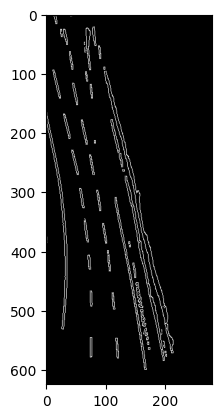

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def birdseye_transform(camera_image, inverse=False):
    OUT_H_FACTOR = 8
    IMAGE_H = 223
    IMAGE_W = 1280

    src = np.float32([[0, 625], [1280, 625], [0, 0], [1280, 0]])
    dst = np.float32([[620, 625], [1280-620, 625], [0, 0], [1280, 0]])

    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    img = camera_image[445:, :] # Apply np slicing for ROI crop
    warped_img = cv2.warpPerspective(img, M if not inverse else Minv, (1280, 625)) # Image warping
    return warped_img

def preprocess_image(img):
    # Extract white and yellow line marker
    lower_yellow = np.array([20, 100, 100], dtype=np.uint8)
    upper_yellow = np.array([30, 255, 255], dtype=np.uint8)

    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray_image, 150, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_white)

    mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)

    # Canny edge detection
    kernel_size = 5
    gauss_gray = cv2.GaussianBlur(mask_yw_image, (kernel_size, kernel_size), 0)

    low_threshold = 50
    high_threshold = 150
    canny_edges = cv2.Canny(gauss_gray, low_threshold, high_threshold)

    return canny_edges

def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def interpolate_hough(img, lines):
    height, width = img.shape
    interploated_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            # straight line
            if x1 == x2:
                interploated_lines.append([(x1, 0, x2, height)])
                continue
            
            # not straight line
            # if the line is too horizontal, skip
            slope = get_slope(x1,y1,x2,y2)
            if np.rad2deg(np.arctan(abs(slope))) < 80 or np.rad2deg(np.arctan(abs(slope))) > 110:
                continue
            
            m_inv = (x2-x1)/(y2-y1)
            interpolated_x1 = m_inv * (0 - y1) + x1
            interpolated_x2 = m_inv * (height - y1) + x1
            interploated_lines.append([(interpolated_x1, 0, interpolated_x2, height)])
    return np.asarray(interploated_lines, dtype=np.int32)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines_interpolated = interpolate_hough(img, lines)
    lines_interpolated = filter_merge_hough(img, lines_interpolated)
    # return lines
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    draw_lines_raw(line_img, lines_interpolated)
    return line_img

def filter_merge_hough(img, lines, lane_width=15):
    filtered = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            matched = False
            for l in range(len(filtered)):
                closest = 10000000
                for x1f, y1f, x2f, y2f in filtered[l]:
                    if x1f == np.inf:
                        if abs(x2-x2f) < lane_width and abs(x2-x2f) < closest:
                            filtered[l] = [(x1, y1, (x2 + x2f)/2, y2)]
                            matched = True
                            closest = abs(x2-x2f)
                    elif abs(x1-x1f) < lane_width or abs(x2-x2f) < lane_width:
                        filtered[l] = [((x1 + x1f)/2, y1, (x2 + x2f)/2, y2)]
                        matched = True
            if matched == False:
                filtered.append([(x1, y1, x2, y2)])
    
    return np.asarray(filtered, dtype=np.int32)

# Return [[x11, x12, ..., xmn], ..., [xi1, ..., xmn]]
def multi_segment_hough(img, rho, theta, threshold, min_line_len, max_line_gap, segment_count=4, lane_width=15):
    segment_width, segment_height = img.shape[1]//segment_count, img.shape[0]//segment_count
    all_segment_lines = []
    for i in range(segment_count-1, 0, -1):
        img_s = img[i*segment_height:(i+1)*segment_height]
        prev_lines = [] if i == segment_count-1 else all_segment_lines[0].tolist()   # prev lines always in first place
        for line in prev_lines:
            for l in line:
                l[2] = l[0]
                l[0] = np.inf
        lines = cv2.HoughLinesP(img_s, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap).tolist() + prev_lines
        lines_interpolated = interpolate_hough(img_s, lines)
        lines_filtered = filter_merge_hough(img_s, lines_interpolated, lane_width=15)   
        all_segment_lines.insert(0, lines_filtered)
    
    # line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # for i in range(len(all_segment_lines) - 1, -1, -1):
    #     for line_segments in all_segment_lines[i]:
    #         for line in line_segments:
    #             line[1] += (i + 1) * segment_height
    #             line[3] += (i + 1) * segment_height
    #     draw_lines_raw(line_img, all_segment_lines[i])
    # return line_img

    flattened_segment_lines = []
    for segment_lines in all_segment_lines:
        temp = []
        for line in segment_lines:
            for x1,y1,x2,y2 in line:
                temp.append([x1, y1, x2, y2])
        temp.sort(key=lambda x: x[2])
        flattened_segment_lines.append(temp)

    # Connect each segment
    result_segment_lines = []
    rsls = result_segment_lines     # shorten the name
    fsls = flattened_segment_lines
    for j in range(len(fsls[-1])):
        temp = [fsls[-1][j][0], fsls[-1][j][2]]
        for i in range(len(fsls)-2, -1, -1):
            matched = False
            for k in range(len(fsls[i])):
                if abs(fsls[i][k][2] - temp[0]) < lane_width:
                    # temp.insert(0, temp[0])
                    temp.insert(0, fsls[i][k][0])
                    matched = True
                    break
            if not matched:
                x2 = temp[0]
                x1 = temp[1]
                m_inv = (x2-x1)/(segment_height)
                interpolated_x2 = m_inv * (segment_height * 2 - 0) + x1
                temp.insert(0, interpolated_x2)
                # temp.insert(0, temp[0])
        rsls.append(temp)
    
    return rsls

def draw_multi_segment_hough(img, lines, segment_count=4):
    '''
    Draw result segment lines
    '''
    segment_height = img.shape[0] // segment_count

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for j in range(len(lines)):
        for i in range(len(lines[j]) - 1):
            y1 = int((i + 1) * segment_height)
            y2 = int((i + 2) * segment_height)
            cv2.line(line_img, (int(lines[j][i]), y1), (int(lines[j][i + 1]), y2), (255, 0, 0), 10)
    
    return line_img

    

cv_image = cv2.imread('images/input10.png')
transformed_image = birdseye_transform(cv_image)[:, 500:1280-500]
canny_edges = preprocess_image(transformed_image)

# plt.imshow(np.asarray(transformed_image, dtype=int))
plt.imshow(np.asarray(canny_edges, dtype=int), cmap='gray')

abs 7
abs 0
abs 3
m_inv -0.09615384615384616
abs 0
m_inv -0.14743589743589744
abs 10
m_inv -0.16025641025641027
abs 10
m_inv -0.21794871794871795


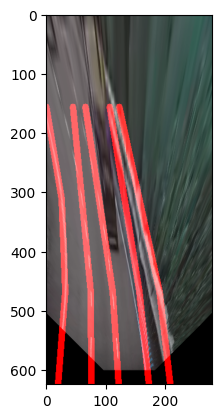

In [283]:
#rho and theta are the distance and angular resolution of the grid in Hough space
#same values as quiz
rho = 4
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 50
min_line_len = 25
max_line_gap = 100
#my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

# hough_lines_img = hough_lines(canny_edges[156*2:156*3], rho, theta, threshold, min_line_len, max_line_gap)
# result = weighted_img(hough_lines_img, transformed_image[156*2:156*3], α=0.8, β=1., λ=0.)

hough_lines_img = multi_segment_hough(canny_edges[:], rho, theta, threshold, min_line_len, max_line_gap, segment_count=4, lane_width=15)
result = weighted_img(hough_lines_img, transformed_image[:], α=0.8, β=1., λ=0.)

plt.imshow(result)

## Video

In [2]:
video_name = 'video01'
input_file_name = f"video/{video_name}.mp4"
output_file_name = f"output/{video_name}_lane_hough.mp4"

import json
from sort.lane_tracking import SortLane

sort_lane = SortLane(iou_threshold=500)

cap = cv2.VideoCapture(input_file_name)

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width, height = 1280-(500*2), 625
no_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
out = cv2.VideoWriter()
out.open(output_file_name, fourcc, fps, (width, height), True)

# Parameters
rho = 4
theta = np.pi/180
threshold = 50
min_line_len = 25
max_line_gap = 100
# Lanes result
lanes = []
try:
    for f in range(no_of_frames):
        ret, frame = cap.read()
        if not ret:
            break

        im = frame
        transformed_image = birdseye_transform(im)[:, 500:1280-500]
        canny_edges = preprocess_image(transformed_image)

        hough_lines = multi_segment_hough(canny_edges, rho, theta, threshold, min_line_len, max_line_gap, segment_count=4, lane_width=10)
        if len(hough_lines) > 0:
            hough_lines, X = sort_lane.update(np.array(hough_lines))
        else:
            hough_lines, X = sort_lane.update(np.empty((0, 4)))
        
        hough_lines_img = draw_multi_segment_hough(canny_edges, hough_lines, segment_count=4)
        im = weighted_img(hough_lines_img, transformed_image[:], α=0.8, β=1., λ=0.)

        # write the frame
        lanes.append(hough_lines.tolist())
        out.write(im)
except Exception as error:
    # Release resources
    import traceback
    print(traceback.format_exc())
finally:
    out.release()
    cap.release()

# Add to frames detections
with open(f'output/{video_name}_lanes.json', 'w', encoding='utf-8') as f:
    json.dump({ "lanes": lanes }, f, ensure_ascii=False, indent=4)

## 3D Lane

In [12]:
import trimesh

lane_tmesh = trimesh.load('objs3/Lane.obj')
lane_tmesh.visual.vertex_colors = [255, 255, 0, 255]
lane_tmesh.show()

In [20]:
cv_image = cv2.imread('images/input6.png')
height = int(cv_image.shape[0]) # row y
width = int(cv_image.shape[1]) # col x

cameraInfo = Info({
    "focalLengthX": int(width / 100) * 100, # 1200.6831,         # focal length x
    "focalLengthY": int(height / 100) * 100, # 1200.6831,         # focal length y
    "opticalCenterX": int(width / 2), # 638.1608,        # optical center x
    "opticalCenterY": int(height / 2), # 738.8648,       # optical center y
    "cameraHeight": 1500, # 1879.8,  # camera height in `mm`
    "pitch": 2.5,           # rotation degree around x
    "yaw": 0,              # rotation degree around y
    "roll": 0              # rotation degree around z
})
ipmInfo = Info({
    "inputWidth": width,
    "inputHeight": height,
    "left": 50,
    "right": width-50,
    "top": 475,
    "bottom": height
})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


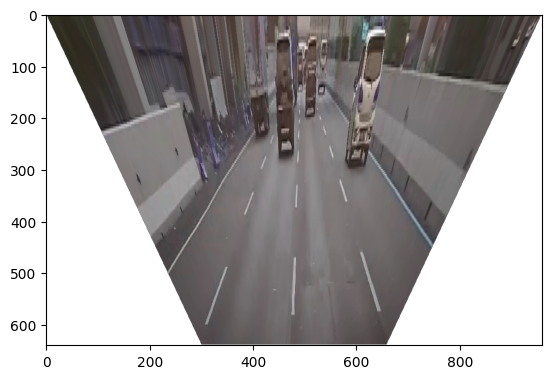

In [21]:
transformed_image = ipm_transform(cv_image, cameraInfo, ipmInfo)
plt.imshow(np.asarray(transformed_image, dtype=int))